In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression

In [ ]:
original_data = pd.read_csv('/content/HOUSE PRICE.csv')

In [ ]:
original_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
data = original_data.drop(['date', 'street', 'country'], axis=1)

In [ ]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,statezip
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,WA 98133
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,WA 98119
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,WA 98042
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,WA 98008
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,WA 98052


In [ ]:
#Feature removal based on the mutual information
features = list(data.columns[1:])
output = data['price'].values.reshape(-1, 1)
mir_result = {}
for col in features:    
    if data[col].dtype != np.float64 and data[col].dtype != np.int64:
        feature_factorized, _ = data[col].factorize() 
        m = mutual_info_regression(output, feature_factorized, random_state=0)
    else:
        m = mutual_info_regression(output, data[col], random_state=0)
    mir_result[col] = m

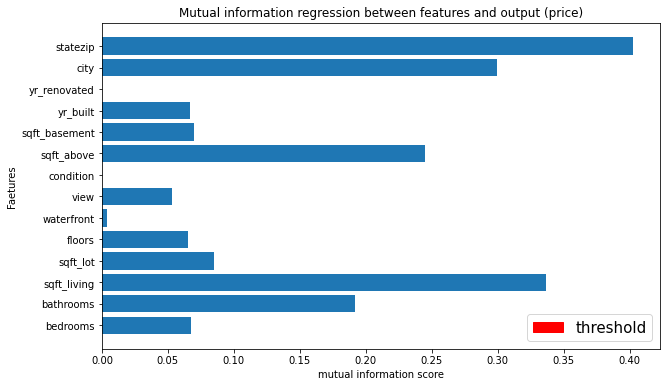

In [ ]:
x = list(mir_result.keys())
y = [score[0] for score in list(mir_result.values())]
plt.figure(figsize=(10,6))
plt.barh(x, y)
plt.title("Mutual information regression between features and output (price)")
plt.xlabel("mutual information score")
plt.ylabel("Faetures")
red_patch= ptch.Patch(color="red", label="threshold")
plt.legend(handles=[red_patch], loc=4, prop={'size': 15})
plt.show()

In [ ]:
# Remove features with threshold 0.05

threshold = 0.05
new_columns = []
for col,mir in mir_result.items():
    if mir > threshold:
        new_columns.append(col)
new_columns.append('price')
data = data[new_columns]

In [ ]:
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,city,statezip,price
0,3.0,1.50,1340,7912,1.5,0,1340,0,1955,Shoreline,WA 98133,313000.0
1,5.0,2.50,3650,9050,2.0,4,3370,280,1921,Seattle,WA 98119,2384000.0
2,3.0,2.00,1930,11947,1.0,0,1930,0,1966,Kent,WA 98042,342000.0
3,3.0,2.25,2000,8030,1.0,0,1000,1000,1963,Bellevue,WA 98008,420000.0
4,4.0,2.50,1940,10500,1.0,0,1140,800,1976,Redmond,WA 98052,550000.0


In [ ]:
data.shape

(4600, 12)

In [ ]:
#Outlier detection with Z-score
columns = list(data.columns)
rows_to_drop = []
for col in columns:
    if data[col].dtype != np.float64 and data[col].dtype != np.int64:
        continue
    z_scores = stats.zscore(data[col])
    for i in range(len(z_scores)):
        if abs(z_scores[i]) > 3:
            rows_to_drop.append(i)

rows_to_drop = sorted(list(set(rows_to_drop)))
data = data.drop(rows_to_drop)
data.reset_index(drop=True, inplace=True)

In [ ]:
data.shape


(4247, 12)

In [ ]:
# seperate the Dependent (y) and Independent (X) variables

y = data.iloc[:, -1].values       # price column
X = data.iloc[:, :-1].values

In [ ]:
#Encoding
# City and Statezip are categorical. 

state_zip_index = list(data.columns).index("statezip")
city_index = list(data.columns).index("city")
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [city_index, state_zip_index])], remainder='passthrough')
X = ct.fit_transform(X)

In [ ]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=1)

In [ ]:
#MultiLinear Regression

mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)
r2_mlr = r2_score(y_test, y_pred_mlr)
mae_mlr = mean_absolute_error(y_test, y_pred_mlr)
print("R2 score for multi linear Regression:  {}".format(r2_mlr))
print("Mean Absolute Error for multi linear Regression:  {}".format(mae_mlr))

R2 score for multi linear Regression:  0.7716666224610041
Mean Absolute Error for multi linear Regression:  81566.67867671241
